# TP 4 : Fillrates

BROSSETTE Camille  
LEGRAND Maxime

## 0. Set-up

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from datetime import datetime

In [2]:
num = [720, 1102, 1662, 1664, 2255, 2574, 2586, 5685, 8695864]
dft = {}
for i in range(1, 10):
    dft[i] = pd.read_pickle("../data4/strades_info_"+str(num[i-1])+".h5")

In [3]:
for i in range(1,10):
    dti = dft[i]['ts_market'].iloc[0]
    dft[i] = dft[i][(dft[i]['bid'] < dft[i]['ask'])
                    &(dft[i]['bid'] != 0)
                    &(dft[i]['bid'] != 999999)
                    &(dft[i]['ask'] != 0)
                    &(dft[i]['ask'] != 999999)
                    &(dft[i]['source'] == 'LSE')
                    &(dft[i]['volume'] != 0)
                    &(dft[i]['qty'] != 0)
                    &(dft[i]['side'] != 'U')]
    if i==2:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 7, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 15, 30))]
    else:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 8, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 16, 30))]

In [4]:
tick = [0.05, 0.05, 0.1, 0.01, 0.05, 0.1, 0.1, 0.1, 0.05]

In [5]:
for i in range(1,10):
    dft[i]['bid1']=dft[i]['bid']-tick[i-1]
    dft[i]['bid2']=dft[i]['bid']-2*tick[i-1]
    dft[i]['ask1']=dft[i]['ask']+tick[i-1]
    dft[i]['ask2']=dft[i]['ask']+2*tick[i-1]

In [6]:
trades = {}
for i in range(1,10):
    trades[i] = dft[i].set_index('ts_market')

## I. Passive Orders and Probability of Execution

### 1. Functions

In [7]:
def Bid_proba_ex(Trades, time_step):
    
    Bid_dist = ['bid', 'bid1', 'bid2']
    
    Bid = np.array([Trades[Bid_dist[0]].resample(time_step).first(),
                    Trades[Bid_dist[1]].resample(time_step).first(),
                    Trades[Bid_dist[2]].resample(time_step).first()])
                    
    Trade = Trades['price'].resample(time_step).min()
    
    res = np.array([[(Trade[i]<Bid[0][i]) for i in range(len(Bid[0]))],
                   [(Trade[i]<Bid[1][i]) for i in range(len(Bid[1]))],
                   [(Trade[i]<Bid[2][i]) for i in range(len(Bid[2]))]])
    
    resf = np.array([res[0].mean(),
                     res[1].mean(),
                     res[2].mean()])
    
    return resf    

In [8]:
def Ask_proba_ex(Trades, time_step):
    Ask_dist = ['ask', 'ask1', 'ask2']
    
    Ask = np.array([Trades[Ask_dist[0]].resample(time_step).first(),
                    Trades[Ask_dist[1]].resample(time_step).first(),
                    Trades[Ask_dist[2]].resample(time_step).first()])
                    
    Trade = Trades['price'].resample(time_step).max()
    
    res = np.array([[(Trade[i]>Ask[0][i]) for i in range(len(Ask[0]))],
                   [(Trade[i]>Ask[1][i]) for i in range(len(Ask[1]))],
                   [(Trade[i]>Ask[2][i]) for i in range(len(Ask[2]))]])
    resf = np.array([res[0].mean(),
                     res[1].mean(),
                     res[2].mean()])
    
    return resf

### 2. Curves

In [9]:
J = 5 # Dataset used from now
t0 = 30 # Minimum time
T = 150 # Maximum time
dt = 30 # Time step in range

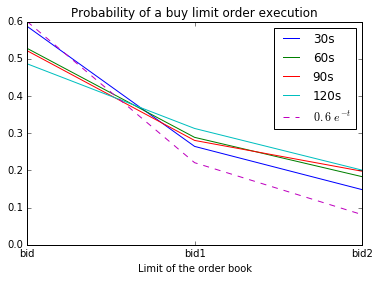

In [10]:
f, ax = plt.subplots()

for s in range(t0,T,dt):
    P_Bid = Bid_proba_ex(trades[J], (str(s) + 's'))
    ax.plot([0,1,2], P_Bid/P_Bid.sum(), label = (str(s) + 's'))
    
ax.plot([0,1,2], [0.6*np.exp(0), 0.6*np.exp(-1), 0.6*np.exp(-2)], '--', label = '$0.6\ e^{-t}$')
    
ax.set_title('Probability of a buy limit order execution')
ax.set_xlabel('Limit of the order book')
ax.set_xticks([0,1,2])
ax.set_xticklabels(('bid', 'bid1', 'bid2'))
ax.legend()

plt.show()

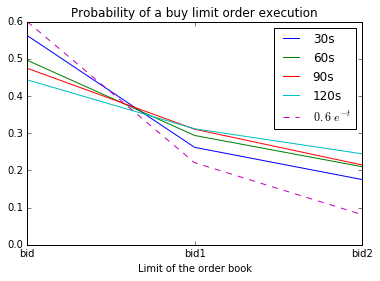

In [11]:
f, ax = plt.subplots()

for s in range(t0,T,dt):
    P_Ask = Ask_proba_ex(trades[J], (str(s) + 's'))
    ax.plot([0,1,2], P_Ask/P_Ask.sum(), label = (str(s) + 's'))
    
ax.plot([0,1,2], [0.6*np.exp(0), 0.6*np.exp(-1), 0.6*np.exp(-2)], '--', label = '$0.6\ e^{-t}$')
    
ax.set_title('Probability of a buy limit order execution')
ax.set_xlabel('Limit of the order book')
ax.set_xticks([0,1,2])
ax.set_xticklabels(('bid', 'bid1', 'bid2'))
ax.legend()

plt.show()

On remarque que lorsque le pas de temps tend vers $0$, les probabilités semblent converger vers une fonction exponentielle. Les graphes ci-dessus les mettent en correspondance avec $t \mapsto 0.6\ e^{-t}$. On observe une symétrie des paramètres de l'exponentielle entre le `bid` et l'`ask`.

## II. Fillrate

### 1. Function

In [12]:
def Fillrate(Trades, dist, time_step, time_waiting):
    Bid_dist = ['bid', 'bid1', 'bid2']
    Bid = Trades[Bid_dist[dist]].resample(time_step).first()
    Trade = Trades['price'].resample(time_step).min()
    
    Res = Trade
    for i in range(len(Bid)):
        Res[i] = (Trade[i]<Bid[i])
    
    res = Res.resample(time_waiting).sum()    
    
    return res

Comme dans l'énoncé, on fait les test avec une quantité $q=1$, plus simple à implanter et bien assez représentatif de la donnée que l'on cherche à représenter.

### 2. Plotting functions

In [13]:
def floor(x):
    return int(np.floor(x))

In [14]:
def disp(x):
    if (x==0):
        return '00'
    else:
        return str(x)

In [15]:
def plotFillRate(d=0, dt='10s', DT='5Min', Hm=8, HM=16.5, J=J, Width=16): 
    # The alignment works bad for J=2
    
    # Time values
    hm = floor(Hm)
    mm = floor((Hm-hm)*60)
    hM = floor(HM)
    mM = floor((HM-hM)*60)
    
    # Declare
    temp_trades = trades[J][(trades[J].index > datetime(dti.year, dti.month, dti.day, hm, mm))
                         &(trades[J].index < datetime(dti.year, dti.month, dti.day, hM, mM))]
    frate = Fillrate(temp_trades, d, dt, DT)
    price = temp_trades['price'].resample(DT).mean()
        
    # Plot
    color = ['lightgreen', 'orange', 'cyan']
    
    f, ax = plt.subplots(2, figsize=(Width,4), sharex=True)
    ax[0].plot(np.linspace(Hm,HM,len(price)), price, color='blue',
               label='Price from '+disp(hm)+':'+disp(mm)+' to '+disp(hM)+':'+disp(mM))
    ax[0].legend()
    ax[0].set_title('Fillrate for $d='+str(d)+'$, $dt=$'+dt+' and $\Delta T=$'+str(DT))
    ax[1].bar(np.linspace(Hm,HM,len(frate)), frate, label='Fillrate for $d='+str(d)+'$', width=0.05, color=color[d])
    ax[1].legend()
    
    plt.show()

### 3. Curves

On donne ci-dessous des exemples d'utilisation de la fonction `plotFillRate`, que le lecteur est invité à expérimenter. On remarquera l'apparence lissée de la courbe de prix, provenant des transformations la rendant homogène au temps et comparable aux _fillrates_. On peut changer l'ensemble de données avec le paramètre `J` et la largeur du tracé avec `Width` (initialement à `16`, n'hésitez pas à l'agrandir si vous disposez d'un écran d'une taille suffisante).

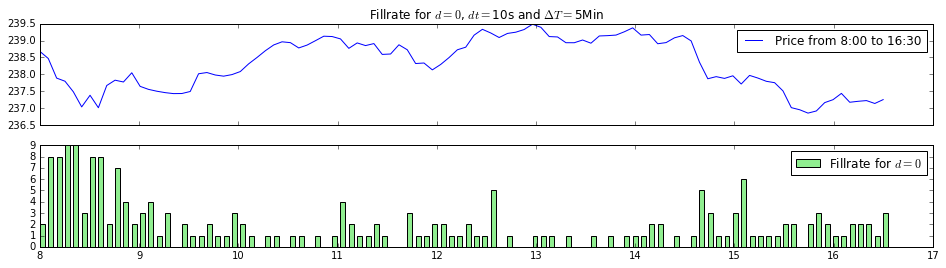

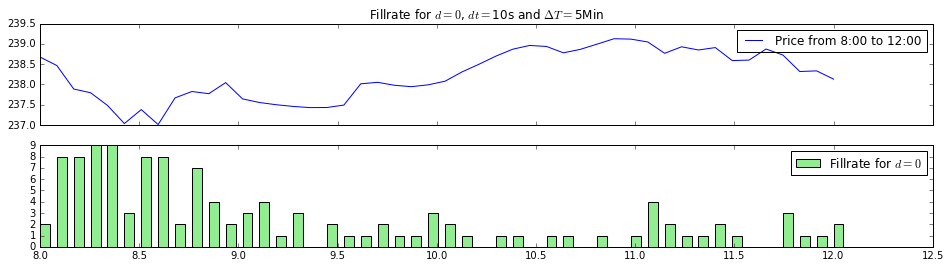

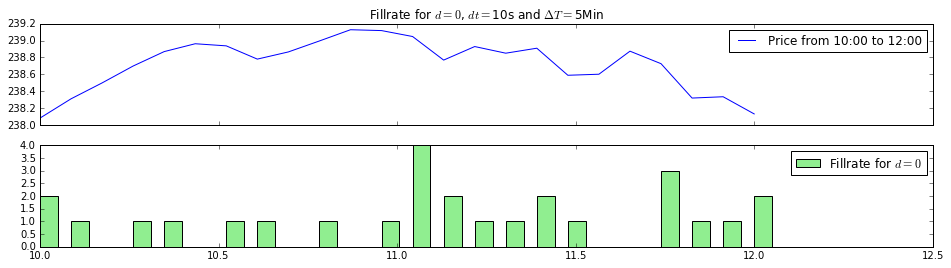

In [16]:
# Exemple 1 : Tracés pour différentes plages horaires

plotFillRate(Hm=8, HM=16.5)
plotFillRate(Hm=8, HM=12)
plotFillRate(Hm=10, HM=12)

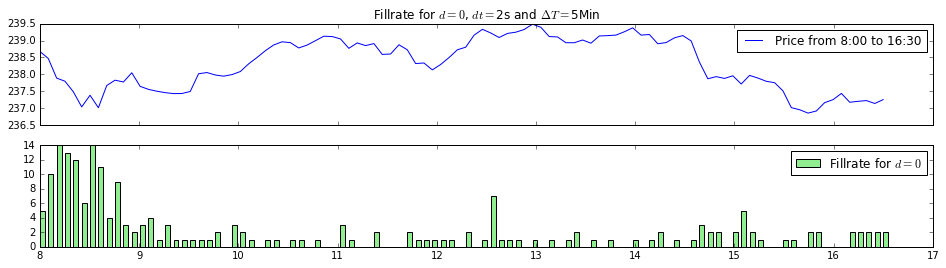

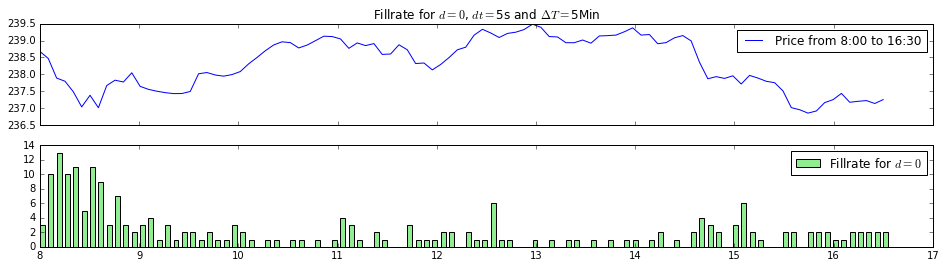

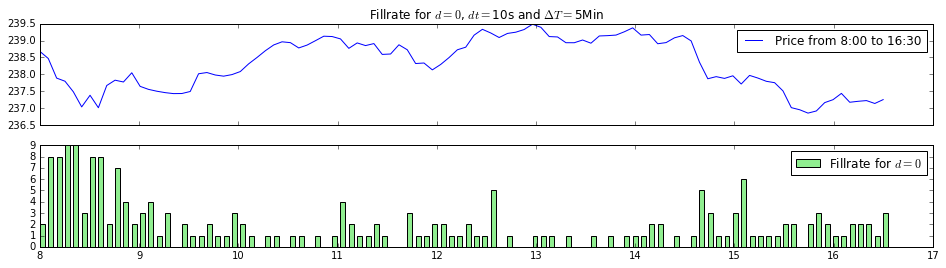

In [17]:
# Exemple 2 : Tracé pour différentes échelles de temps

plotFillRate(dt='2s', DT='5Min')
plotFillRate(dt='5s', DT='5Min')
plotFillRate(dt='10s', DT='5Min')

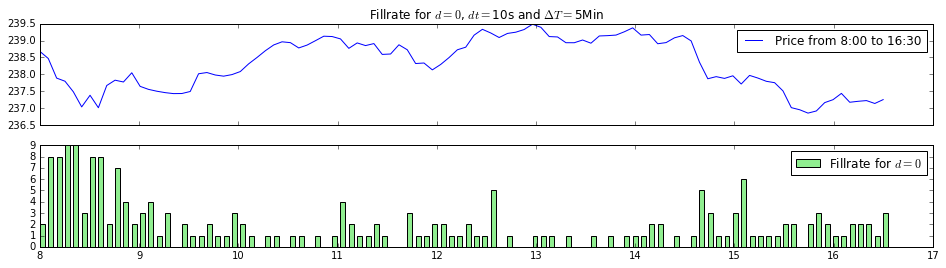

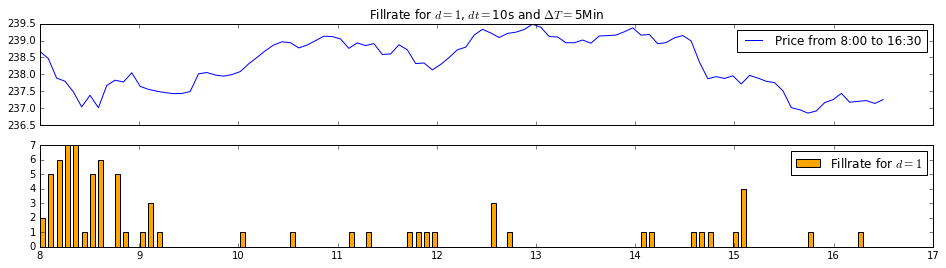

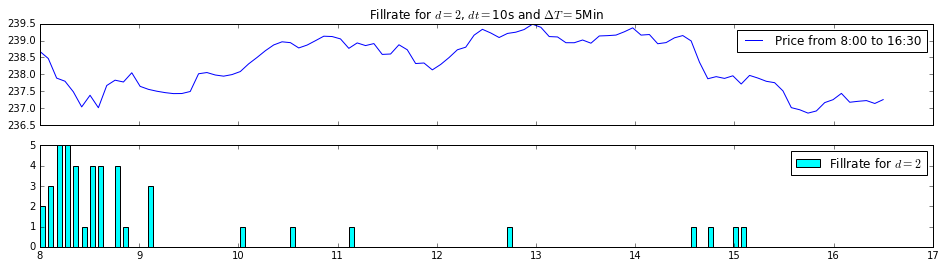

In [18]:
# Exemple 3 : Tracés pour différentes distances

for d in range(0,3): plotFillRate(d=d)

## III. Inventory and Market Making

### 1. Inventory

#### Regular plots

In [19]:
def plotInventory(d_l=[0,1,2], dt='10s', DT_l=['10Min','5Min','2Min'], Hm=8, HM=16.5, J=J,
                  rows = 1, cols = 1, Width=16, Height=8): 
    # The alignment works bad for J=2
    
    # Time values
    hm = floor(Hm)
    mm = floor((Hm-hm)*60)
    hM = floor(HM)
    mM = floor((HM-hM)*60)
    
    # Declare
    temp_trades = trades[J][(trades[J].index > datetime(dti.year, dti.month, dti.day, hm, mm))
                         &(trades[J].index < datetime(dti.year, dti.month, dti.day, hM, mM))]
        
    # Plot
    f, ax = plt.subplots(rows, cols, figsize=(Width,Height))
    ax.set_title('Inventory for $d\in'+str(d_l)+'$, $dt=$'+dt+' and $\Delta T\in$'+str(DT_l))
    for d in d_l:
        for DT in DT_l:
            inv = Fillrate(temp_trades, d, dt, DT).cumsum()
            ax.step(np.linspace(Hm,HM,len(inv)), inv, label='$d='+str(d)+',\ \Delta T=$'+DT)
    ax.legend(loc=2)
    
    plt.show()

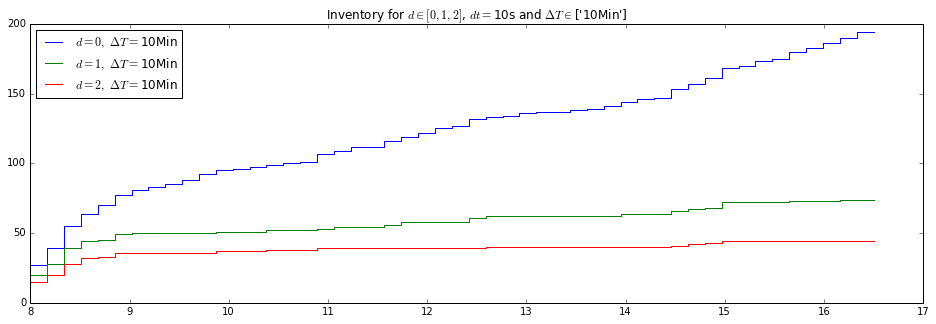

In [20]:
plotInventory(DT_l=['10Min'], Height=5)

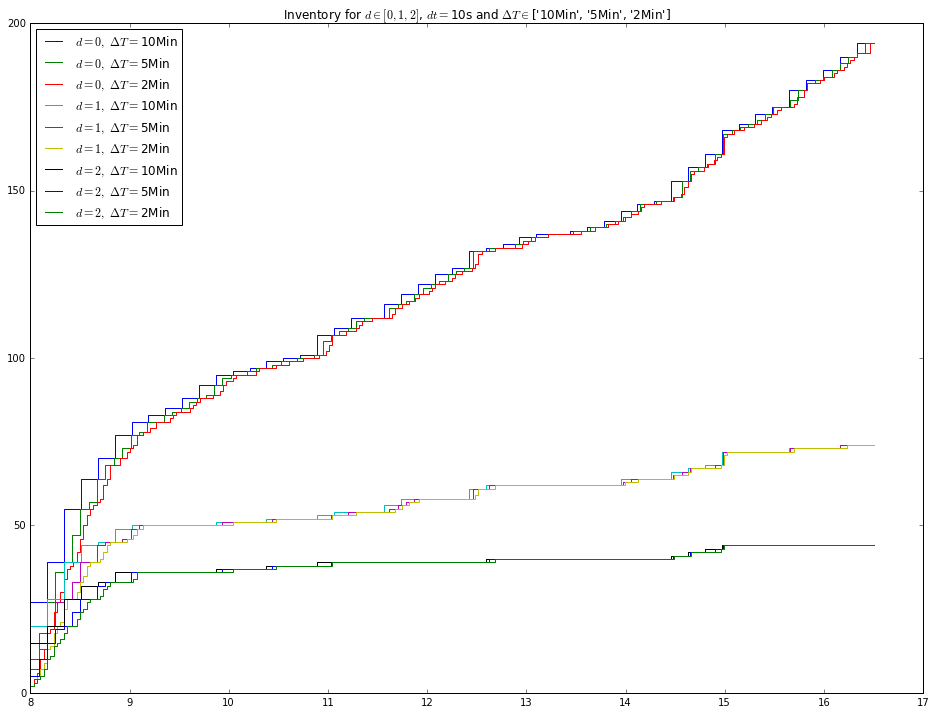

In [21]:
plotInventory(Height=12)

#### Comparison with Volatility $\sigma$ and Spread $S$

On remarque que, l'inventaire $V$ étant une intégrale discrète du _Fillrate_ $FR$, on a $dV_t=FR(t)$.

In [22]:
def plotComparedInventory(d_l=[0,1,2], dt='10s', DT_l=['10Min','5Min','2Min'], Hm=8, HM=16.5, J=J,
                  rows = 1, cols = 1, Width=16, Height=8, vol=True, spread=True): 
    # The alignment works bad for J=2
    
    # Time values
    hm = floor(Hm)
    mm = floor((Hm-hm)*60)
    hM = floor(HM)
    mM = floor((HM-hM)*60)
    
    # Declare
    temp = trades[J][(trades[J].index > datetime(dti.year, dti.month, dti.day, hm, mm))
                         &(trades[J].index < datetime(dti.year, dti.month, dti.day, hM, mM))]
        
    # Plot
    if vol:
        f1, ax1 = plt.subplots(rows, cols, figsize=(Width,Height))
        ax1.set_title('$\partial V_t/\partial \sigma_t$ for $d\in'+str(d_l)+'$, $dt=$'+dt+' and $\Delta T\in$'+str(DT_l))
        for DT in DT_l:
            vol = (((temp['price']-temp['price'].shift()).apply(lambda x: x**2)).resample(DT).sum()).apply(np.sqrt)
            vol = vol/vol.mean()
            dvol = vol-vol.shift()
            for d in d_l:
                frate = Fillrate(temp, d, dt, DT)
                ax1.step(np.linspace(Hm,HM,len(frate)), frate/dvol,
                        label='$d='+str(d)+',\ \Delta T=$'+DT)
        ax1.legend()
    
    if spread:
        f2, ax2 = plt.subplots(rows, cols, figsize=(Width,Height))
        ax2.set_title('$\partial V_t/\partial S_t$ for $d\in'+str(d_l)+'$, $dt=$'+dt+' and $\Delta T\in$'+str(DT_l))
        for DT in DT_l:
            spread = (temp['ask'] - temp['bid']).resample(DT).mean()
            spread = spread/spread.mean()
            dspread = spread-spread.shift()
            for d in d_l:
                frate = Fillrate(temp, d, dt, DT)
                ax2.step(np.linspace(Hm,HM,len(frate)), frate/dspread,
                        label='$d='+str(d)+',\ \Delta T=$'+DT)
        ax2.legend()
    
    plt.show()

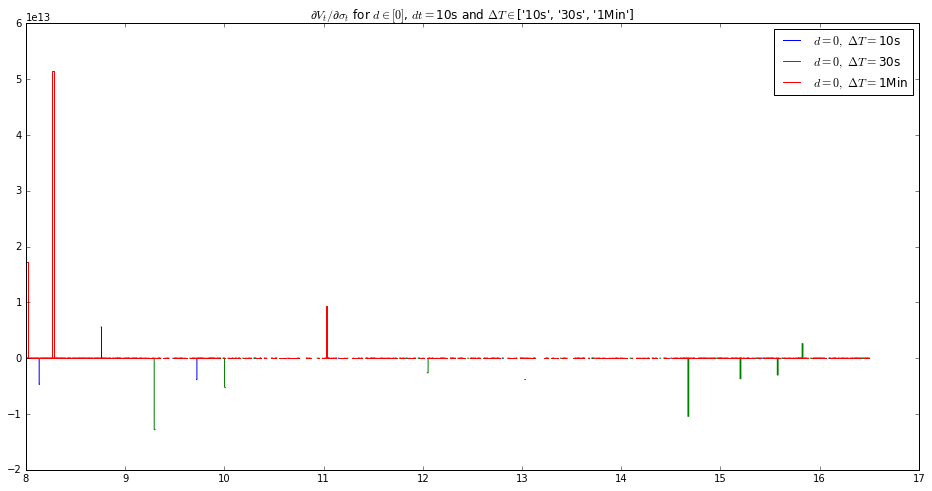

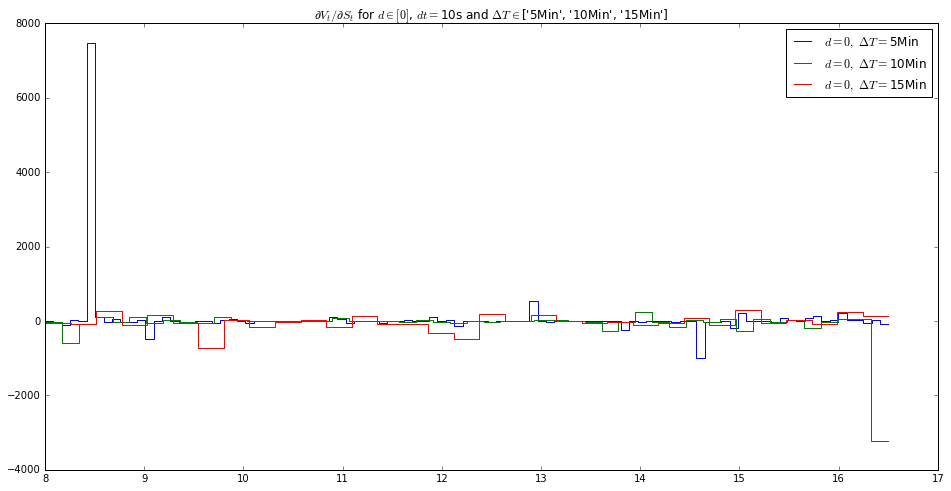

In [23]:
plotComparedInventory(d_l=[0], DT_l=['10s','30s','1Min'], spread=False)
plotComparedInventory(d_l=[0], DT_l=['5Min','10Min','15Min'], vol=False)

### 2. Static Market Making

### 3. Dynamical Market Making

## IV. Profit & Loss

## Conclusion